3. Dataset statistics and feature ranking 
Please provide data set statistical description and the rank of the feature, and possible 
explanations for the same. Use the right feature importance/ranking method.

• Provide statistical summary of the dataset 
• Perform feature ranking (use correlation or SHAP, feature importance – give them 
open ended)
• Demonstrate your understanding of PCA for feature reduction and later in section 4 perform the comparative analysis of the model before and after performing PCA 
(identify optimal number of features). 

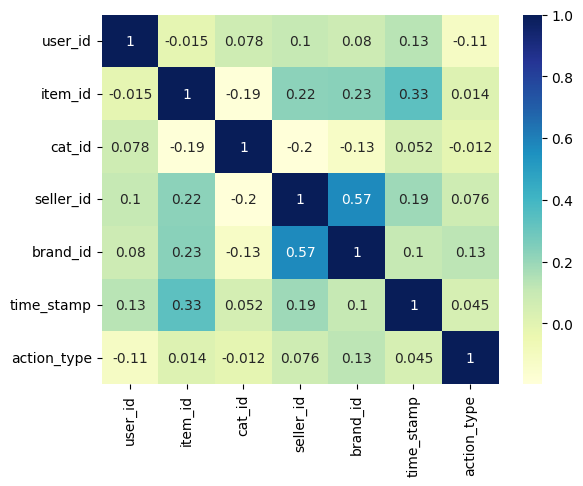

In [59]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()


In [60]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
import pandas as pd

# Load the user behavior logs data
user_behavior_logs = pd.read_csv("/content/drive/MyDrive/PR Project/user_log_format1.csv")

# Load the user profile data
user_profile = pd.read_csv("/content/drive/MyDrive/PR Project/user_info_format1.csv")

# Load the training data
training_data = pd.read_csv("/content/drive/MyDrive/PR Project/train_format1.csv")

# Merge user behavior logs and user profile data on 'user_id'
merged_data = pd.merge(user_behavior_logs, user_profile, on='user_id', how='left')

# Extract features from the merged data

# User demographics features
age_range_mapping = {0: 'unknown', 1: '<18', 2: '[18,24]', 3: '[25,29]', 4: '[30,34]', 5: '[35,39]', 6: '[40,49]', 7: '>= 50', 8: '>= 50'}
merged_data['age_range'] = merged_data['age_range'].map(age_range_mapping)
merged_data = pd.get_dummies(merged_data, columns=['age_range', 'gender'], prefix=['age', 'gender'])

# User behavior features
user_behavior_features = merged_data.groupby('user_id').agg({
    'action_type': ['count', 'sum'],
    'item_id': ['nunique'],
    # Replace 'seller_id' with the correct column name representing the merchant or seller ID
    'seller_id': ['nunique'],
    'cat_id': ['nunique'],
    'brand_id': ['nunique']
})

user_behavior_features.columns = ['total_actions', 'total_purchases', 'unique_items', 'unique_merchants', 'unique_categories', 'unique_brands']
user_behavior_features.reset_index(inplace=True)

# Merge user behavior features with training data on 'user_id' and the correct merchant ID column
# Replace 'seller_id' with the correct column name representing the merchant or seller ID in training_data
final_data = pd.merge(training_data, user_behavior_features, on=['user_id'], how='left')

# Check the final_data
print(final_data.head())

# Save the final_data to a new CSV file
final_data.to_csv("final_data.csv", index=False)


   user_id  seller_id  label  total_actions  total_purchases  unique_items  \
0    34176       3906      0            NaN              NaN           NaN   
1    34176        121      0            NaN              NaN           NaN   
2    34176       4356      1            NaN              NaN           NaN   
3    34176       2217      0            NaN              NaN           NaN   
4   230784       4818      0            NaN              NaN           NaN   

   unique_merchants  unique_categories  unique_brands  
0               NaN                NaN            NaN  
1               NaN                NaN            NaN  
2               NaN                NaN            NaN  
3               NaN                NaN            NaN  
4               NaN                NaN            NaN  


In [62]:
training_data = pd.read_csv("/content/drive/MyDrive/PR Project/train_format1.csv")
print(training_data.head())

   user_id  seller_id  label
0    34176       3906      0
1    34176        121      0
2    34176       4356      1
3    34176       2217      0
4   230784       4818      0


In [63]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('final_data.csv')

# Split the dataset into features (X) and target variable (y)
X = df.drop('label', axis=1)
y = df['label']

# Handle missing values by filling them with the mean of each column
imputer = SimpleImputer()
X = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Model accuracy:", accuracy)


Model accuracy: 0.9185785751250647


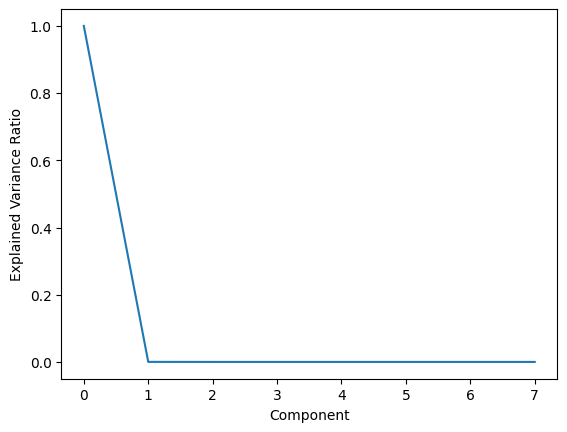

In [64]:
from sklearn.decomposition import PCA

# Initialize a PCA object
pca = PCA()

# Fit the PCA model to the dataset
pca.fit(X)

# Compute the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio using a line chart
sns.lineplot(x=range(len(explained_variance_ratio)), y=explained_variance_ratio)
plt.xlabel("Component")
plt.ylabel("Explained Variance Ratio")
plt.show()


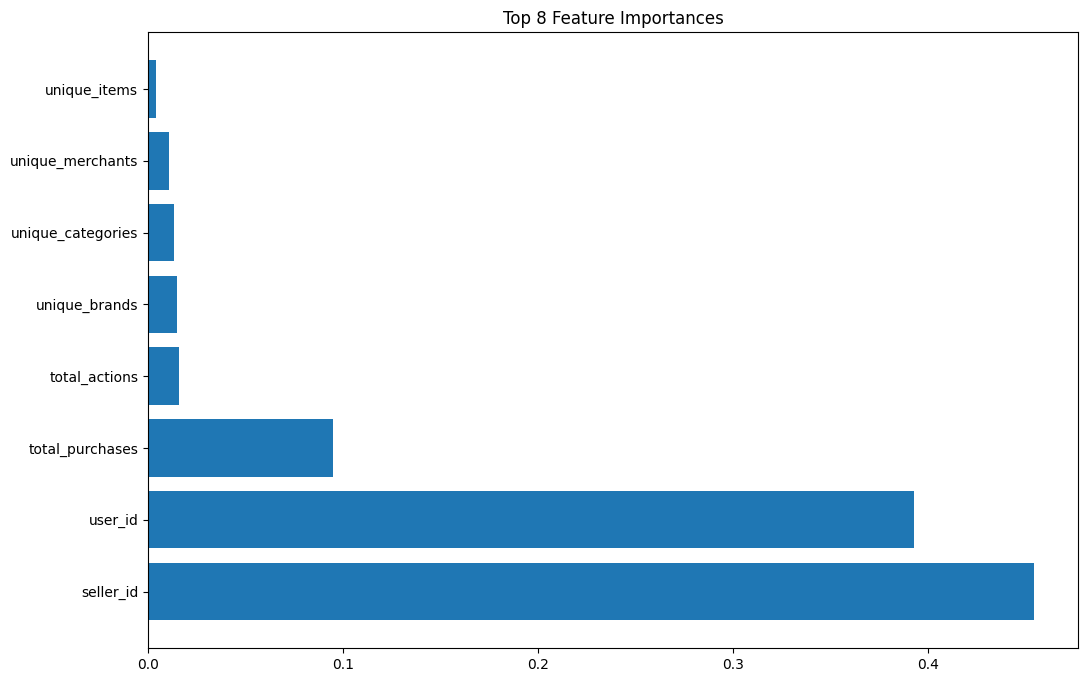

In [134]:
# Load the consolidated dataset
df = pd.read_csv('final_data.csv')



# Remove samples with missing values
df_clean = df.dropna()

# Separate features and target variable from the cleaned dataset
X = df_clean.drop('label', axis=1)
y = df_clean['label']

# Train the random forest regressor on the cleaned data
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X, y)
importances = rf.feature_importances_

feature_names = X.columns

indices = np.argsort(importances)[::-1]

lis = []

for f in range(X.shape[1]):
    if (f < 30):
        lis.append(feature_names[indices[f]])

plt.figure(figsize=(12, 8))
plt.title("Top 8 Feature Importances")
plt.barh(range(8), importances[indices][:8])
plt.yticks(range(8), feature_names[indices][:8])
plt.show()



In [136]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap

# Load data
data = pd.read_csv('/content/drive/MyDrive/PR Project/Final_train.csv')
data=data.drop('repeat_buyer_count_merchant',axis=1)
data=data.drop('user_id',axis=1)

data['time_stamp'] = (data['time_stamp']).astype(int)

# # duration_in_seconds_int = int(duration_in_seconds)
# data=data.drop(['repeat_buyer_count_merchant','merchant_id','avg_user_age_merchant','age_avg_per_merchant'],axis=1)
# # data['purchase_average_time'] = pd.to_datetime(data['purchase_average_time'])
# # convert datetime objects to integers
# data['time_stamp'] = data['time_stamp'].apply(lambda x: int(x.timestamp()))
# # data['purchase_average_time'] = data['purchase_average_time'].apply(lambda x: int(x.timestamp()))
print(data.shape)
data = data.drop_duplicates()
print(data.shape)



(23956, 22)
(23956, 22)


In [137]:
from sklearn.model_selection import train_test_split

X = data.drop(['label'], axis=1)
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [138]:
# Train XGBoost classifier
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


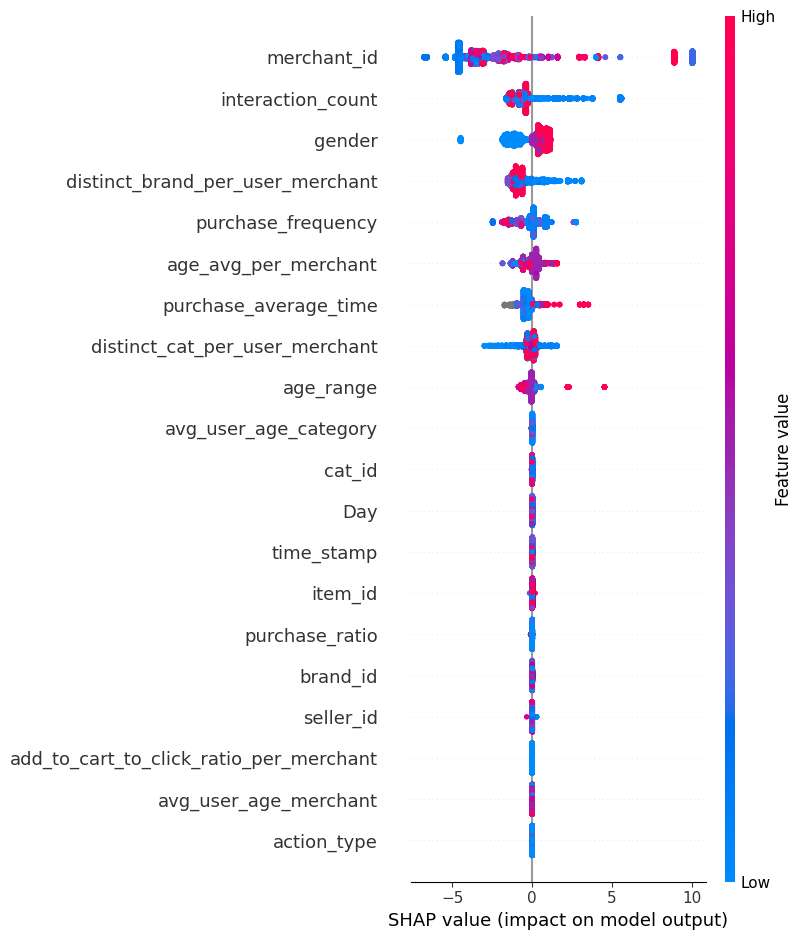

In [139]:
# Create an explainer object
explainer = shap.Explainer(clf)

# Compute SHAP values
shap_values = explainer(X_test)

# Visualize summary plot
shap.summary_plot(shap_values, X_test)